# Clustering


*Davide Gerosa (Milano-Bicocca)* 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 6.

This course is based on previous work by many people. See [here]((https://github.com/dgerosa/astrostatistics_bicocca_2025/blob/main/README.md) for credits.


# How do we determine the optimal algorithm?

We've seen already several times that our algorithms have hyperparameters (the number of bins in an histogram, the bandwidth of a KDE, the number of modes in Gaussian Mixtures, etc etc). Picking by hand is not satisfactory. Often we have some astrophysical knowledge ("I know that there are two distinct formation processes at play for these kind of stars") but let's now look at how we can do this in a purely **data-driven** fashion using [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). See [this guide](https://scikit-learn.org/stable/modules/cross_validation.html) as well.

This is the machine-learning solutions to the good old problem of **model selection** (remember $\chi^2$ and Bayes factors?)

To avoid fooling ourselves into thinking our model is better than it is, we set aside some of the data as the "***test***" set--that provides an independent check on the the fit from the ***training data***. 

That's fine if our model has no parameters, or has parameters that are all fixed ahead of time.  But what if we want to try to use the data to not only fit a model, but decide what the best model parameters are?  In that case, we need to set aside some of the training data as a "***validation***" set.  

This divsion will become crucial when we'll look at deep learning stategies. The reason is that deep learning can behave like a black box which is hard to control. Testing and validating is essentially the *only* way to make sure one is doing something meaninful. So:

- **Training** data are used for the actual fit
- **Validation** data are used to optimize the parameters of the algorithm
- **Test** data are used at the very end to evaluate the overall performance.


There are some obvious issues here. Splitting the data not only does leave us less data for training (and we know less data is bad for machine learning!), but it also means that it matters which objects are in each of the training, validation, and test sets.  We can solve both of these problems with **cross validation**.


1. You could **randomly sample** to decide which data goes into the training or test sets. We don't just do this once, but rather many times so that each data point is treated both as a training point and as a test point at some stage.


2. We could do this in a more ordered way (e.g., to make sure that each object gets sampled as training/test the same number of times) and do a **$K$-fold cross validation**. Here $K$ is the number of "experiments" that need to be done so that each data point appears in a test sample once.


3. We can take $K$-fold cross validation to the extreme by having $K\equiv N$, so that in each experiment we leave out just one object. This is called **"Leave-One-Out" cross validation**.


A 5-fold cross-validation would look like this:

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)


But note this dramatically increases the computational cost! So often we're stuck with running only once (which is the usual test/training approach of deep learning).






Ok let's say it again

- The *training* set is used to learn the model parameters
- The *validation* set is used to tune the (hyper)parameters of the algorithm
- The *test* set is used to test the final performance

(ML people use words "learn" and "tune" with this different flavor).  

- If you're only learning the parameters, you don't need a validation set: test-train splitting. 
- If you're also tuning the hyperparameters: K-fold cross validation
    - Train your algorithm K times
    - Pick the best hyperparameters
    - Run your algorithm again on the full training set.
    - Evaluate performance of the final model on the test set.

Let's go back to our problem of trying to determine the best bandwidth for our Kernel Density Estimate. We can do this in Scikit-Learn with [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and replot our histogram above as follows:

In [1]:
import numpy as np
import scipy.stats as stats
import pylab as plt 


np.random.seed(0)
N = 1000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

print(x)

[ 9.88098175  6.88890031 14.75431527 11.26282659  9.02603826  5.45480032
 14.84834532  7.20202926 11.59381508  8.46234879  6.87805682 -2.42442801
  8.67910115 11.67878423  2.43372946  4.61652587 11.7740746   6.75577056
  5.07316606 11.48368143  6.86297379  4.90119519 10.80139823 11.92500816
 11.40097406  7.01540998  8.3482713   7.75433461 12.17243866  6.67812855
 11.86606764  6.12144632  4.02047079  8.91253481  9.02940286  5.86890351
 13.26472069  6.46044042 11.47707178  1.78891829  7.84483202  8.94316824
  7.14694135  5.97813624 13.55947164  5.89700561  8.69796462  7.7920869
  6.63679814  6.56378375  9.68415753 11.30996966  6.09366003 11.75960737
  6.51807183 12.05155804 12.722903   12.1088272   7.13590034  2.20533002
  6.56010529 15.42536614 14.90886111  6.42474909  7.40539426  8.93699675
  4.42631687  8.17344972  6.09413902  9.09229597 13.27075867  9.00761224
  7.35203988  6.85525011 11.93444513 11.99366982  0.46670497  6.64734517
  5.26873214 12.34943329 22.02293388 10.57789081  9.

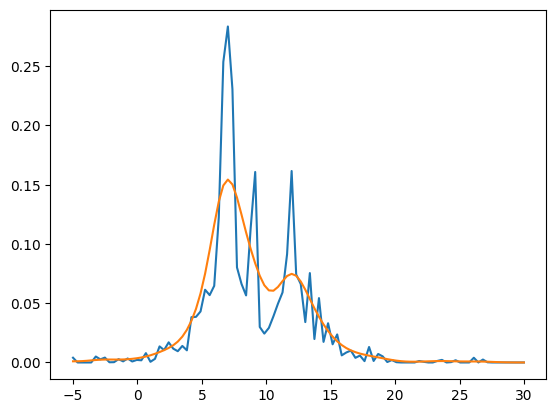

In [2]:
from sklearn.neighbors import KernelDensity

def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

xgrid =np.linspace(-5,30,100)
pdf = kde_sklearn(x,bandwidth=0.1)
plt.plot(xgrid,pdf)
pdf = kde_sklearn(x,bandwidth=1)
plt.plot(xgrid,pdf)

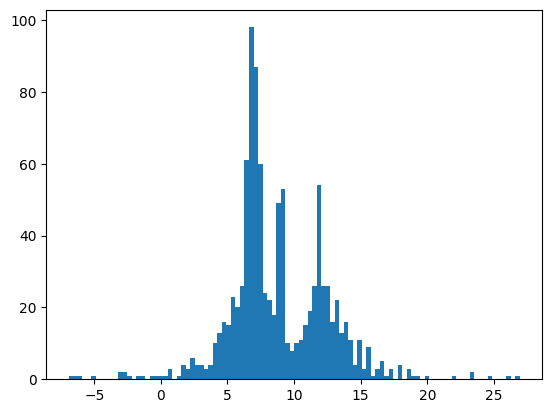

In [3]:
plt.hist(x,bins=100);

In [5]:
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.1 to 1.0
print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(x[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.01       0.03538462 0.06076923 0.08615385 0.11153846 0.13692308
 0.16230769 0.18769231 0.21307692 0.23846154 0.26384615 0.28923077
 0.31461538 0.34       0.36538462 0.39076923 0.41615385 0.44153846
 0.46692308 0.49230769 0.51769231 0.54307692 0.56846154 0.59384615
 0.61923077 0.64461538 0.67       0.69538462 0.72076923 0.74615385
 0.77153846 0.79692308 0.82230769 0.84769231 0.87307692 0.89846154
 0.92384615 0.94923077 0.97461538 1.        ]
0.41615384615384615


Note this is a grid search, not a root finder. It just a convenient wrapper to try all bandwidths and return the best one. For difficult things, you might need a root finder (how you find a maximum? We've done it at lenght!)

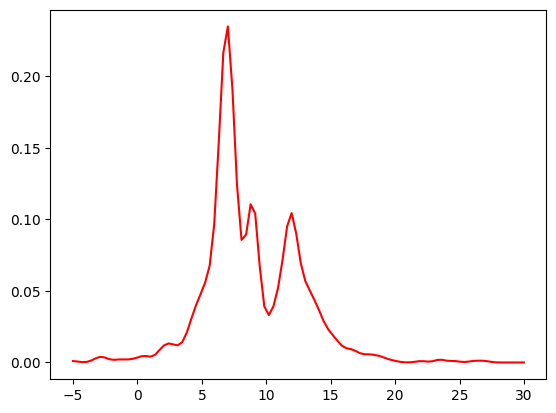

In [7]:
pdf = kde_sklearn(x,bandwidth=h_opt)
plt.plot(xgrid,pdf,c='red');

# Clustering <a class="anchor" id="two"></a>

> *[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) algorithms attempt to group together similar objects in a data set.* 

This process allows us to put new objects into the resulting classes and to identify rare objects that do not fit any particular mold. **Clustering is inherently an "unsupervised" process** as we do not know the classification of the objects. Since we have no metric for determining when we are right, it is a bit of a dark art, but it also can be very powerful. Scikit-Learn's clustering suite is summarized at [http://scikit-learn.org/stable/modules/clustering.html](http://scikit-learn.org/stable/modules/clustering.html).


There are plenty of astrophysical problems where clustering can be useful. As an example, this is a plot of the distributions of Gamma Ray Bursts. Can you see two classes there? These are the so-called short GRBs and long GRBs. The long ones come from supernovae, the short ones come from neutron star mergers.

![](https://ars.els-cdn.com/content/image/1-s2.0-S2214404815000129-gr001_lrg.jpg)

Figure from "The Second Swift BAT Gamma-Ray Burst Catalog", [Sakamoto et al 2011](https://arxiv.org/abs/1104.4689).


### $K$-Means Clustering <a class="anchor" id="twoa"></a>

We start with [$K$-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), which is one of the simplest methods.  $K$-means seeks to minimize the following

$$\sum_{k=1}^{K}\sum_{i\in C_k}||x_i - \mu_k||^2$$

where $\mu_k = \frac{1}{N_k}\sum_{i\in C_k} x_i$

In words, this says to
  * Take every object in class $C_k$ (as determined by which centroid it is closest to, specifically $C_k(x_i) = \arg \min_k ||x_i-\mu_k||)$
  * Compute the mean of the objects in that class
  * Subtract that mean from each member of that class and square the norm
  * Do that for each class and sum
  * Shift the centroids of the *pre-determined* number of classes until this sum is minimized
  * Do this multiple times with different starting centroids and take the result with the minimum sum
  


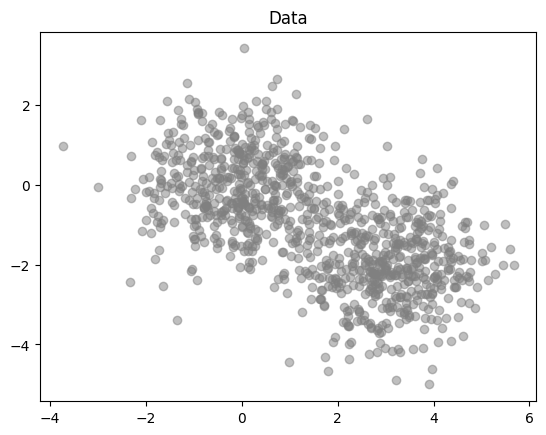

In [10]:
# Generate mock data

mode1= np.random.normal(size=(500,2))
mode2= np.random.normal(loc=[3.0,-2.0], size=(500,2))

#X = np.random.normal(size=(1000,2)) #1000 points in 2D
X = np.concatenate([mode1,mode2]) # 1000  points in 2D

plt.title('Data')
plt.scatter(X[:,0],X[:,1],color='gray',alpha=0.5)


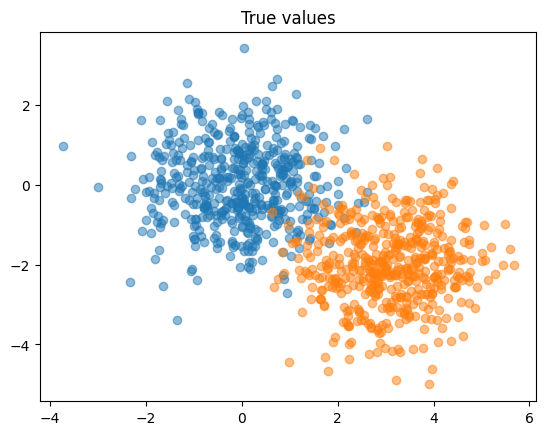

In [11]:
plt.title('True values')
plt.scatter(mode1[:,0],mode1[:,1],color='C0',alpha=0.5)
plt.scatter(mode2[:,0],mode2[:,1],color='C1',alpha=0.5);


A typical scikit-learn call will look something like this

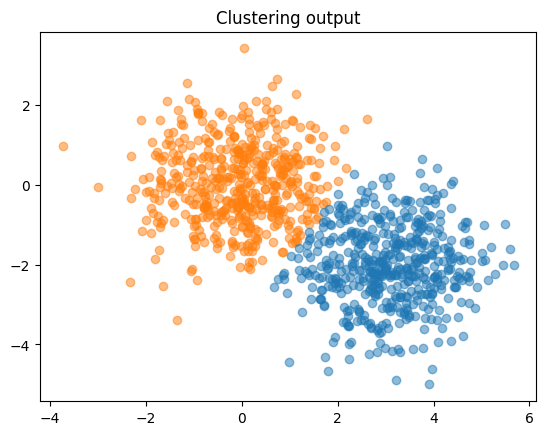

In [12]:

from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

# To get some information on these try:
# KMeans?
# help(clf)
plt.title('Clustering output');

The algorithm does a pretty good job, but it's not perfect

**At home**. Compute the confusion matrix (but remember this is an **unsupervised** method: we didn't use the true labels in any way).

Here is an example of **K-means clustering on some multi-dimensional data**.

In [13]:
# Execute the next few cells
from astropy.table import Table
t = Table.read('./data/cruz_all_dist.dat', format="ascii")

# Turn these data into a properly formatted Scikit-Learn array
X = np.vstack([ t['col2'], t['col3'], t['col4'], t['col5'] ]).T
print(X)

[[13.03636039 -0.11023487  9.04241732  0.        ]
 [13.33267828 -0.10360584  9.35453197  0.68184119]
 [13.14338559 -0.16142859  9.30932842  0.82017946]
 ...
 [ 6.77437708 -0.12553107  5.54210446  7.41862726]
 [ 6.71834403  0.04474092  5.56965196  7.44040775]
 [ 7.02729337  0.12547728  5.55979252  7.49615526]]


This is multi-dimensional data, which is tough to visualize in terms of the raw data and the clusters. Let's do some quick dimensional reduction-- we'll look at this in detail in a few lectures.

Text(0, 0.5, 'Eigenvalue 2')

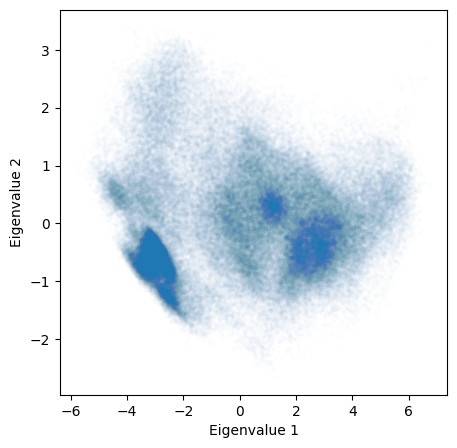

In [14]:
# Project onto 2 axes with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2 components
pca.fit(X) # Do the fitting


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()


X_reduced = pca.transform(X)

ax.scatter(X_reduced[:,0], X_reduced[:,1], 
            marker=".", color='C0', 
            alpha=0.01, edgecolors='None')
ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

The above image shows the data projected into **two linear combinations that encompass the directions of greatest variance**. We'll do $K$-means clustering in these dimensions.

In [15]:
# Compute the KMeans clustering
n_clusters = 6
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters, n_init='auto')
clf.fit(scaler.fit_transform(X_reduced))

KMeans(n_clusters=6, n_init='auto')

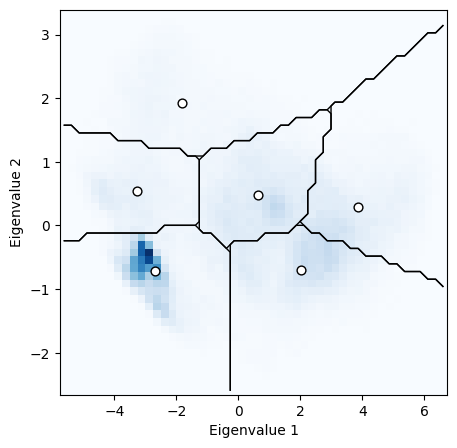

In [16]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

The above figure displays the underlying density of samples, the cluster centers, and the cluster boundaries! Very powerful!

### Mean-shift Clustering <a class="anchor" id="twob"></a>

**Mean-shift clustering** works by finding the modes in a kernel density estimator of the distribution. Clustering is achieved by the ***mean-shift algorithm***:

1. The KDE of the dataset is computed.
2. This allows the gradient of the distribution to be calculated. Easy to do since it's a bunch of overlapping Gaussians.
3. Each data point is shifted in the direction of increasing gradient, which drives the points toward the modes. 
4. This process is iterated until all points have converged with clusters of other points at each of several distinct modes.
5. Each data point is then associated with a cluster of other points.


Let's try this using the same dataset as in $K$-means.

In [17]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
bandwidth = 0.4
#bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X_reduced))

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False)

[-1  0  1  2  3  4  5  6]
0.4
number of estimated clusters : 7


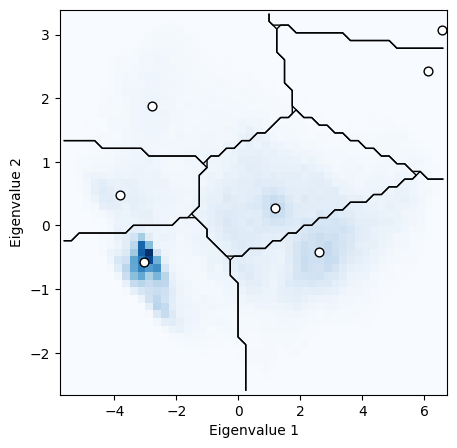

In [18]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

Mean-shift will not only estimate cluster centers and boundaries, but also the number of clusters!

-----
## Additional material, not examinable: Correlation functions

This is something I won't have time to cover in class, but I'll leave it here in case you need it in your research (looking at you my cosmology friend). At least you know where to start from. And there's a nice example with quasars and galaxies, together with a sweet application of bootstrapping...

> ***Correlation functions*** *tell us how far (and on what scales) a distribution of data samples differs from a random distribution.*

They have been used extensively in astrophysics, e.g., 
- examining fluctuations and structure on varying scales of the galaxy density distribution in terms of luminosity, galaxy type, age of the Universe.
- examining the two-point correlation function of temperature fluctuations of the cosmic microwave background to unveil the composition of the Universe.
- searching for long-timescale correlations in time-series data to examine noise in AGN lightcurves or find GW signals in pulsar-timing data.


![](https://www.astroml.org/_images/fig_corr_diagram_1.png)


One of the most prominent is the **two-point correlation function** which characterizes the excess probability of finding pairs of points at varying separations when compared to a random distribution. It can be described in terms of the power spectrum of fluctuations, $P(k)$ where $k=2\pi/\lambda$ and $\lambda$ is the scale/wavelength of the fluctuation:

$$ \xi(r) = \frac{1}{2\pi^2}\int dk\, k^2 P(k)\frac{\sin(kr)}{kr}.$$

This correlation function can be used to describe the density fluctuations of sources by

$$ \xi(r) = \left\langle \frac{\delta\rho(x)}{\rho}\frac{\delta\rho(x+r)}{\rho}\right\rangle,$$

where $\delta\rho(x)/\rho = (\rho-\bar\rho)/\rho$ is the density contrast relative to the mean $\bar\rho$ at position $x$.

In many situations in astronomy or cosmology, the spatial correlation function or angular correlation function is modeled as a power-law, e.g. $w(\theta) = (\theta/\theta_0)^\delta$ (this is astronomy after all, where power-laws rule supreme). Angular correlation functions are often used because we care about *projected structure* on different scales, rather than depth clustering, e.g., in the CMB this kind of angular clustering is indicative of fluctuations in the primordial density field that can unveil the composition of the Universe at the time of last scattering.

Higher $n$-point correlation functions can be computed (see the image above), but the two-point function is the most common. Why? When dealing with large populations of sources spread across the Universe, we can often invoke the central limit theorem to describe the statistical distribution of sources-- hence **correlations can be approximated as obeying Gaussian statistics, which are entirely defined by the mean and two-point correlators (i.e. the variance)**.

In [19]:
# Execute this cell to implement AstroML's two-point correlation function on some random data
from astroML.correlation import two_point_angular

RA = 40 * np.random.random(1000)
DEC = 10 * np.random.random(1000) # ra and dec in degrees

bins = np.linspace(0.1, 10.0, 11) # edges for the 10 bins to evaluate
corr = two_point_angular(RA, DEC, bins, method='landy-szalay')
print(corr)

[-0.02612449  0.0004413  -0.00449078 -0.00738486  0.00756482 -0.00200349
 -0.01148305 -0.00123022  0.01185794 -0.00648073]


Now try the example from Figure 6.17 of the textbook. This computes the angular correlation function for a subset of the SDDS spectroscopic galaxy sample in the range $0.08<z<0.12$. This may take a minute or so to run.

data size:
  red gals:  38017
  blue gals: 16883
@pickle_results: using precomputed results from 'correlation_functions.pkl'


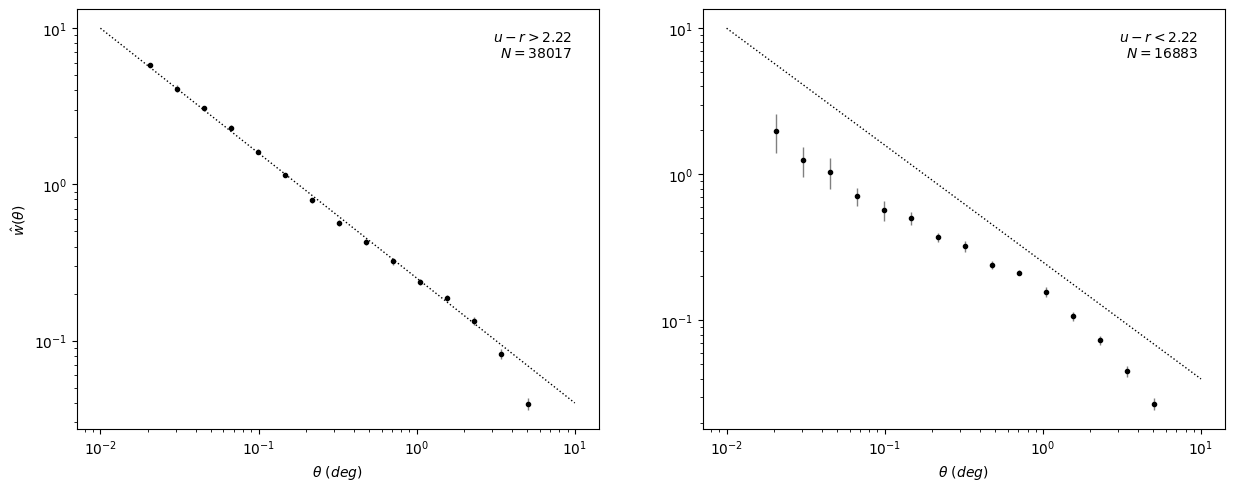

In [24]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular

#------------------------------------------------------------
# Get data and do some quality cuts
data = fetch_sdss_specgals()
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

print("data size:")
print("  red gals: ", len(data_red))
print("  blue gals:", len(data_blue))


#-----------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

#------------------------------------------------------------
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')


plt.show()

The left panel shows red galaxies with $u-r>2.22$ and the right panel shows blue galaxies with $u-r<2.22$. Uncertainties are derived from $10$ bootstrap samplings (do you remember boostrapping? If not see previous lecture...). There is significantly greater correlation structure on small angular scales in red galaxies than in blue galaxies. 

With tens of thousands of galaxies in each sample, this code has been optimized using **Scikit-Learn's ball-tree method for computing the correlation function-- further details given in Chapter 2, Section 2.52**.

-----

## Time to get your hands dirty! Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



#### Python tip. Web request and smarter file reading

In [ ]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

[My exploration](https://github.com/dgerosa/astrostatistics_bicocca_2025/blob/main/solutions/S15_gammaraybursts.ipynb) which, by the way, does not answer all the questions above...